# **НАБОР ДАННЫХ "ants/bees"**

**AlexNet**

In [1]:
# Загрузка библиотек:
!pip install torch torchvision
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from ipywidgets import FloatProgress

from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path

plt.ion()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#Разбитие на обучающую и тестовую выборки датасета "CIFAR10":
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = Path(r'/content/sample_data/hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(data_dir / x, data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
#Число изображений в выборках:
print(dataset_sizes)

{'train': 244, 'val': 153}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


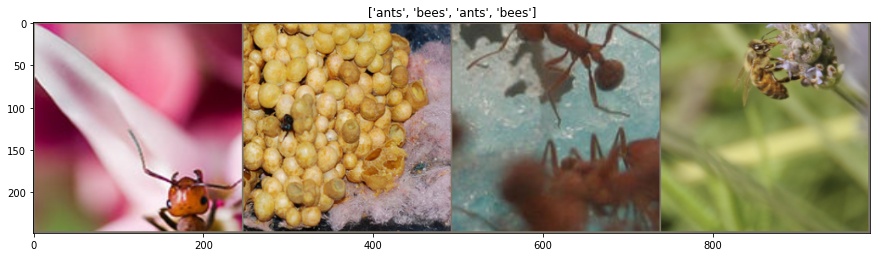

In [11]:
#Вывод одного батча изображений:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

**СТАНДАРТНАЯ МОДЕЛЬ**

In [15]:
#Настройка функии обучения нейронной сети:
def train_model(model, criterion, optimizer, scheduler, num_epochs=14):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  
            else:
                model.train(False)  

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]      
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses

print ('Число эпох было изменено на 14, так как по функции лосса это число оптимально')

Число эпох было изменено на 14, так как по функции лосса это число оптимально


In [16]:
#Настройка функции визуализации:
def visualize_model(model, num_images=4):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [17]:
#Настройка функции проверки точности на тестовой выборке:
def evaluate(model):
    model.train(False)
    
    runninig_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data
        
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [18]:
#Установка параметров нейронной сети:
model = models.alexnet(pretrained=True)
num_features = 9216
model.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.001)
print('Уменьшен step_size, чтобы веса обновлялись как можно часто, остальные показатели так же были уменьшены с целью более тщательной перевроверки')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Уменьшен step_size, чтобы веса обновлялись как можно часто, остальные показатели так же были уменьшены с целью более тщательной перевроверки


In [20]:
#Обучение нейронной сети:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=14)
print ('Уменьшено число эпох с целью оптимизации времени (после 14 уже не оптимальные параметры)')

Epoch 0/13
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2555 Acc: 0.4672
val Loss: 0.2405 Acc: 0.5359

Epoch 1/13
----------
train Loss: 0.2606 Acc: 0.4426
val Loss: 0.2425 Acc: 0.5359

Epoch 2/13
----------
train Loss: 0.2458 Acc: 0.4385
val Loss: 0.2407 Acc: 0.5359

Epoch 3/13
----------
train Loss: 0.2625 Acc: 0.4426
val Loss: 0.2405 Acc: 0.5359

Epoch 4/13
----------
train Loss: 0.2560 Acc: 0.4631
val Loss: 0.2508 Acc: 0.5359

Epoch 5/13
----------
train Loss: 0.2453 Acc: 0.4918
val Loss: 0.2579 Acc: 0.5359

Epoch 6/13
----------
train Loss: 0.2650 Acc: 0.4508
val Loss: 0.2487 Acc: 0.5359

Epoch 7/13
----------
train Loss: 0.2678 Acc: 0.4344
val Loss: 0.2427 Acc: 0.5359

Epoch 8/13
----------
train Loss: 0.2561 Acc: 0.4508
val Loss: 0.2579 Acc: 0.5359

Epoch 9/13
----------
train Loss: 0.2441 Acc: 0.4631
val Loss: 0.2435 Acc: 0.5359

Epoch 10/13
----------
train Loss: 0.2574 Acc: 0.4754
val Loss: 0.2400 Acc: 0.5359

Epoch 11/13
----------
train Loss: 0.2766 Acc: 0.4016
val Loss: 0.2418 Acc: 0.5359

Epoch 12/13
----------
t

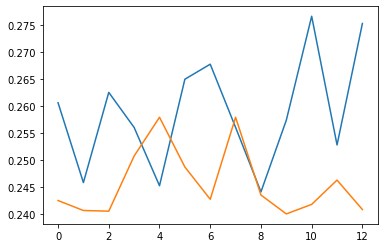

In [21]:
#Построение графика лосса при обучении и валидации:
plt.plot(losses['train'][1:])
plt.plot(losses['val'][1:])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


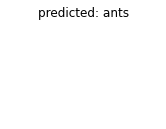

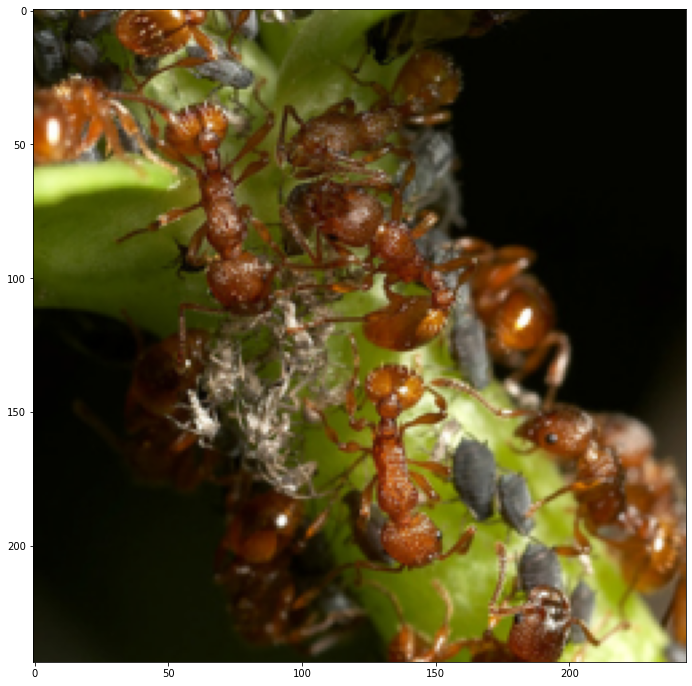

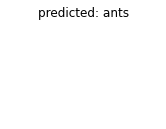

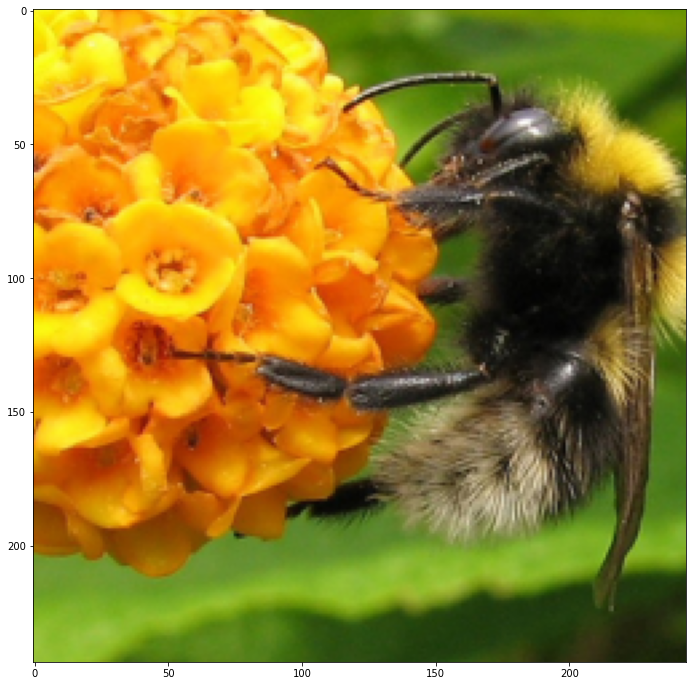

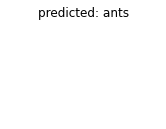

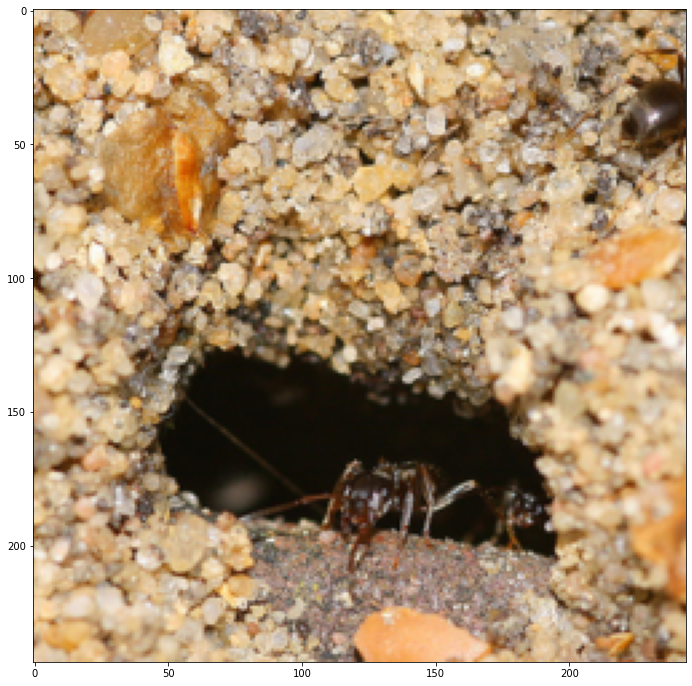

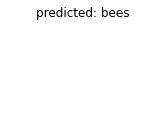

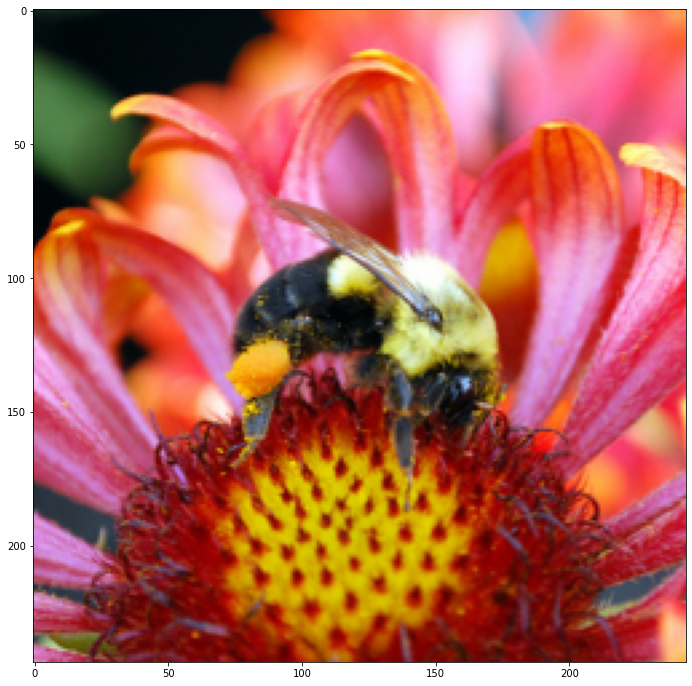

In [22]:
#Визуализация работы модели:
torch.save(model.state_dict(), '1AlexNet_fine_tune.pth')
model.load_state_dict(torch.load('1AlexNet_fine_tune.pth'))
visualize_model(model)

In [26]:
#Точность работы модели:
print("Accuracy: {0:.4f}".format(evaluate(model)))
print ('\n','Точность работы является неудолетворительной')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy: 0.5359

 Точность работы является неудолетворительной


**Transfer learning**

In [27]:
#Прогонка модели снова:
model_extractor = models.alexnet(pretrained=True)
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [28]:
#Определене параметров новой модели:
for param in model_extractor.parameters():
    param.requires_grad = False


num_features = 9216
model_extractor.classifier = nn.Linear(num_features, 2)


if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.1, momentum=0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)

In [30]:
#Обучение вновь запущенной модели:
%%time
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=16)
print('Увеличим количество эпох с прошлого обучения')

Epoch 0/15
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 9.1954 Acc: 0.8770
val Loss: 17.1260 Acc: 0.8627

Epoch 1/15
----------
train Loss: 11.4153 Acc: 0.8566
val Loss: 17.3557 Acc: 0.8758

Epoch 2/15
----------
train Loss: 11.7881 Acc: 0.8525
val Loss: 26.6052 Acc: 0.8562

Epoch 3/15
----------
train Loss: 7.4488 Acc: 0.8934
val Loss: 22.6399 Acc: 0.8366

Epoch 4/15
----------
train Loss: 10.6046 Acc: 0.8648
val Loss: 15.8240 Acc: 0.8627

Epoch 5/15
----------
train Loss: 6.0297 Acc: 0.9139
val Loss: 14.0177 Acc: 0.8824

Epoch 6/15
----------
train Loss: 7.3369 Acc: 0.8770
val Loss: 15.3269 Acc: 0.8366

Epoch 7/15
----------
train Loss: 7.4011 Acc: 0.8893
val Loss: 14.1249 Acc: 0.8758

Epoch 8/15
----------
train Loss: 7.3088 Acc: 0.9139
val Loss: 15.5617 Acc: 0.8562

Epoch 9/15
----------
train Loss: 8.8780 Acc: 0.8934
val Loss: 13.2157 Acc: 0.8758

Epoch 10/15
----------
train Loss: 4.0630 Acc: 0.9385
val Loss: 14.4870 Acc: 0.8366

Epoch 11/15
----------
train Loss: 4.4981 Acc: 0.9303
val Loss: 14.4624 Acc: 0.8693

Epoch 12/

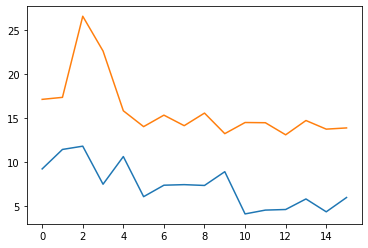

In [31]:
#Построение графика лосса при обучении и валидации вновь запущенной модели:
plt.plot(losses['train'])
plt.plot(losses['val'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


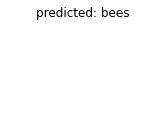

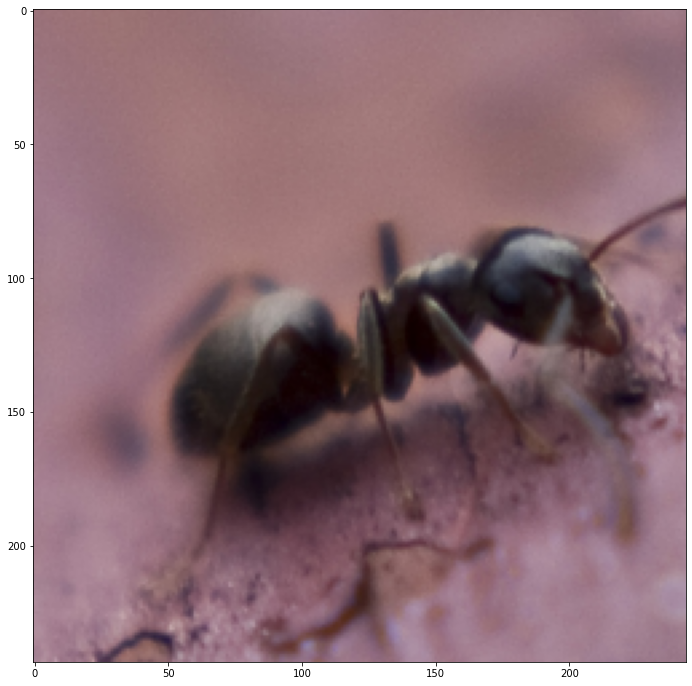

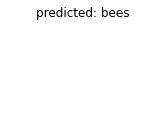

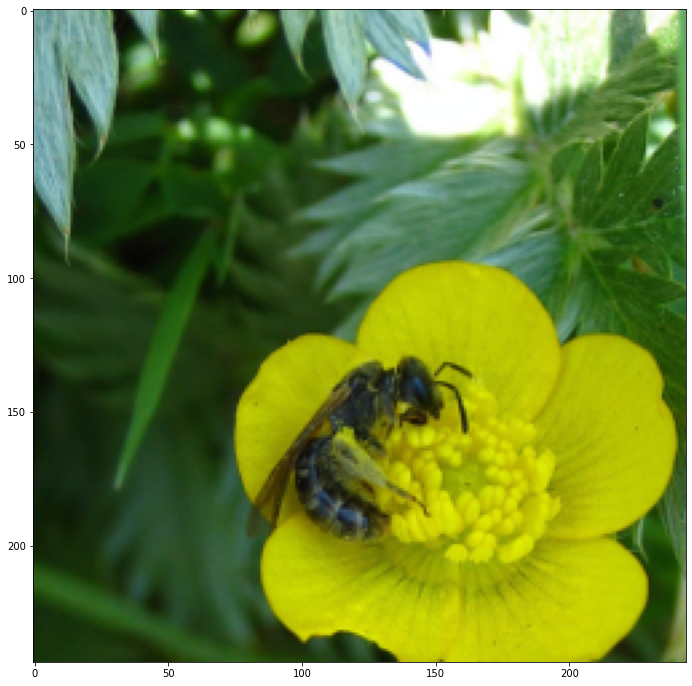

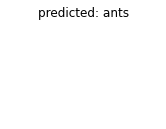

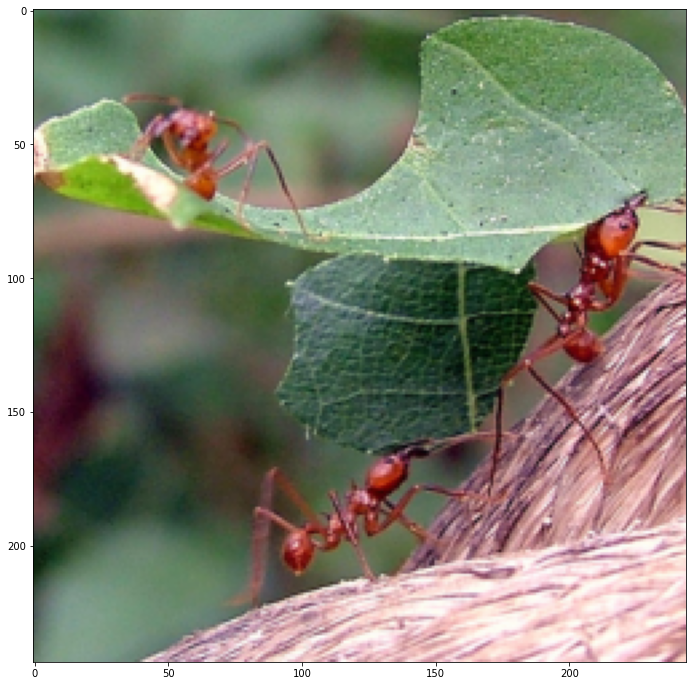

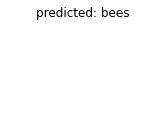

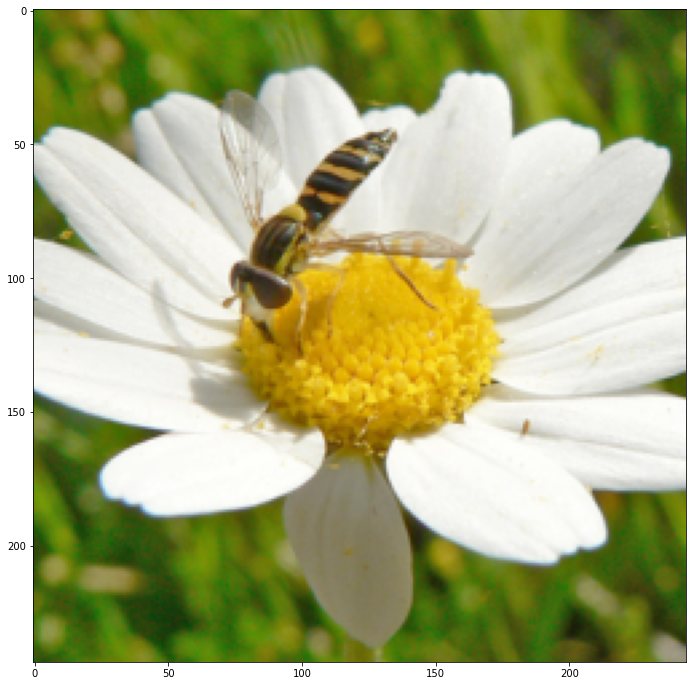

In [32]:
#Визуализация работы новой модели:
torch.save(model_extractor.state_dict(), '2AlexNet_extractor.pth')
model_extractor.load_state_dict(torch.load('2AlexNet_extractor.pth'))
visualize_model(model_extractor)

In [36]:
#Проверка точности новой модели:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))
print('\n', 'Качество стало довольно лучше и является отличным показателем')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy: 0.9020

 Качество стало довольно лучше и является отличным показателем


**Смешанный** способ:
Мы будем обучать не только последний **fully connected** слой, но и несколько предпоследних **bold text**

In [38]:
#Использование уже предобученной модели:
model_mixed = models.alexnet(pretrained=True)

In [56]:
#Формирование параметров модели:
layers_to_unfreeze = 2

for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 9216

model_mixed.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model_mixed = model_mixed.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print('В связи с отличными показателями ранее обученной модели показатели в примере не меняем, но всё же разморозим 2 слоя, а не 5, чтобы не допустить переобучения модели')

В связи с отличными показателями ранее обученной модели показатели в примере не меняем, но всё же разморозим 2 слоя, а не 5, чтобы не допустить переобучения модели


In [57]:
#Обучение модели:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=14)

Epoch 0/13
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.0479 Acc: 0.9139
val Loss: 0.1463 Acc: 0.8824

Epoch 1/13
----------
train Loss: 0.0299 Acc: 0.9508
val Loss: 0.1493 Acc: 0.8758

Epoch 2/13
----------
train Loss: 0.0281 Acc: 0.9631
val Loss: 0.1522 Acc: 0.9020

Epoch 3/13
----------
train Loss: 0.0226 Acc: 0.9672
val Loss: 0.1913 Acc: 0.9085

Epoch 4/13
----------
train Loss: 0.0304 Acc: 0.9467
val Loss: 0.1753 Acc: 0.8889

Epoch 5/13
----------
train Loss: 0.0312 Acc: 0.9426
val Loss: 0.2045 Acc: 0.8954

Epoch 6/13
----------
train Loss: 0.0271 Acc: 0.9508
val Loss: 0.2036 Acc: 0.8954

Epoch 7/13
----------
train Loss: 0.0293 Acc: 0.9672
val Loss: 0.2035 Acc: 0.8954

Epoch 8/13
----------
train Loss: 0.0266 Acc: 0.9508
val Loss: 0.2031 Acc: 0.8954

Epoch 9/13
----------
train Loss: 0.0271 Acc: 0.9672
val Loss: 0.2381 Acc: 0.8889

Epoch 10/13
----------
train Loss: 0.0145 Acc: 0.9918
val Loss: 0.2091 Acc: 0.8954

Epoch 11/13
----------
train Loss: 0.0225 Acc: 0.9713
val Loss: 0.2023 Acc: 0.8954

Epoch 12/13
----------
t

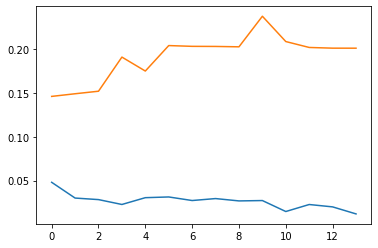

In [58]:
#Визуализация функции лосса:
plt.plot(losses['train'])
plt.plot(losses['val'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


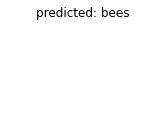

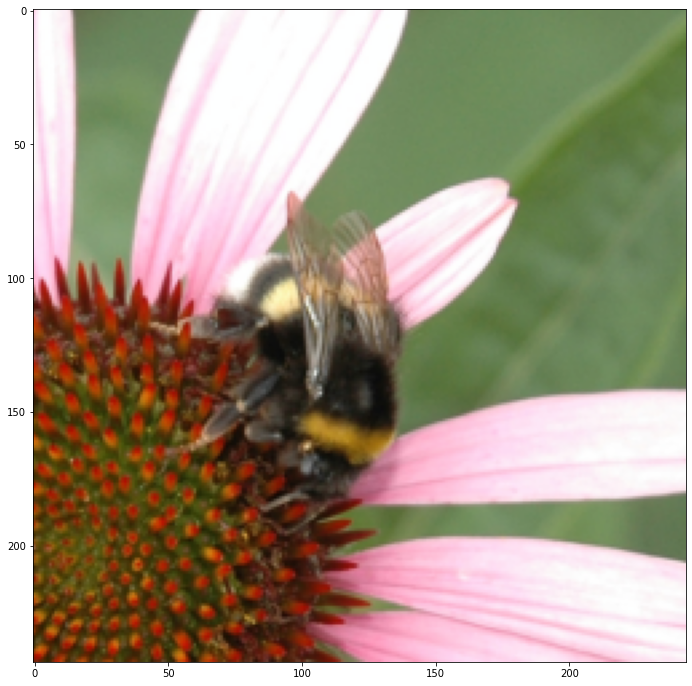

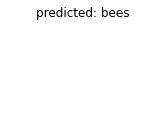

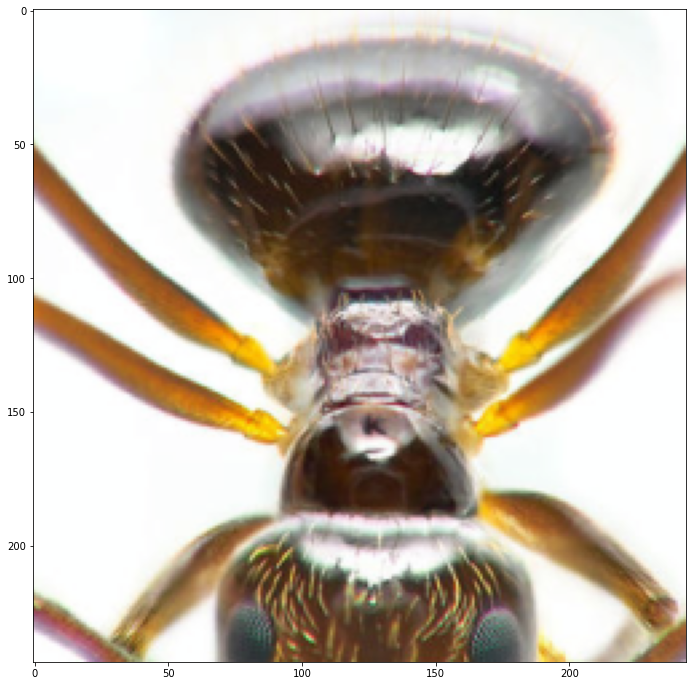

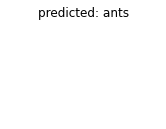

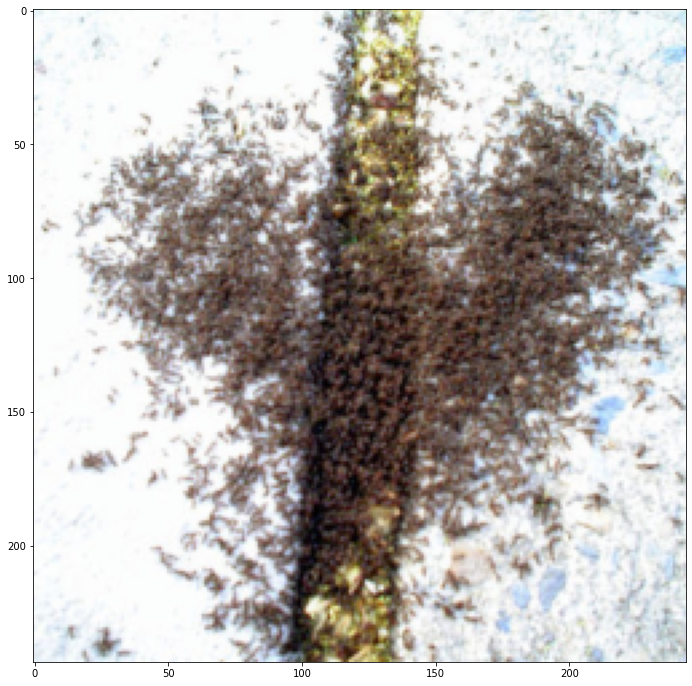

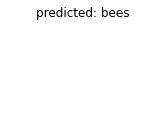

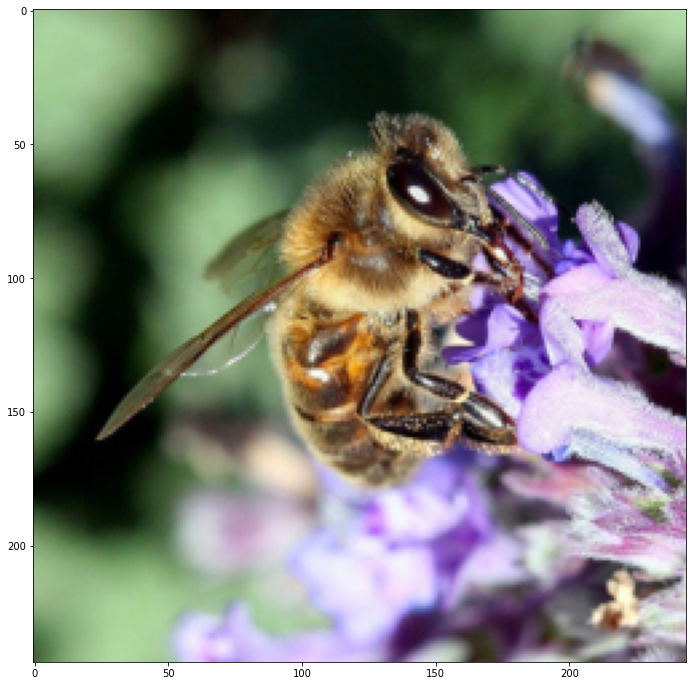

In [59]:
#Визуализация работы модели:
torch.save(model_mixed.state_dict(), '3AlexNet_mixed.pth')
model_mixed.load_state_dict(torch.load('3AlexNet_mixed.pth'))
visualize_model(model_mixed)

In [60]:
#Расчёт точности модели:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))
print('Модель стала работать немного хуже, но результаты приемлимые')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy: 0.8954
Модель стала работать немного хуже, но результаты приемлимые


### VGG16

In [61]:
#Формируем параметры модели:
model_extractor = models.vgg16(pretrained=True)

for param in model_extractor.parameters():
    param.requires_grad = False

num_features = 25088
model_extractor.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print('Попробуем развернуть модель, менея параметры в примере')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Попробуем развернуть модель, менея параметры в примере


In [62]:
#Обучение модели:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.3997 Acc: 0.7910
val Loss: 0.4176 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4781 Acc: 0.9016
val Loss: 0.5115 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4371 Acc: 0.8852
val Loss: 0.6730 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.2996 Acc: 0.9180
val Loss: 0.5426 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4371 Acc: 0.9139
val Loss: 0.6720 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.2127 Acc: 0.9344
val Loss: 0.5994 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.2622 Acc: 0.9303
val Loss: 0.6000 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.1678 Acc: 0.9631
val Loss: 0.5848 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.1706 Acc: 0.9549
val Loss: 0.5875 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.1628 Acc: 0.9631
val Loss: 0.5726 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.0976 Acc: 0.9631
val Loss: 0.7736 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.1014 Acc: 0.9344
val Loss: 0.5439 Acc: 0.9216

Epoch 12/24
----------
t

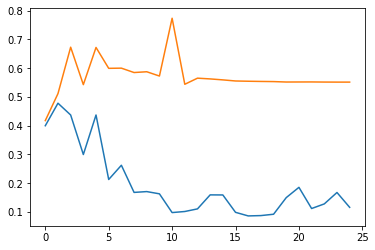

In [63]:
#Визуализация функции лоса:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [73]:
torch.save(model_extractor.state_dict(), '4VGG16.pth')
model_extractor.load_state_dict(torch.load('4VGG16.pth'))
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))
print('\n', 'Пока что это наилучший результат')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy: 0.9281

 Пока что это наилучший результат


**Inception_v3**

In [76]:
#Формирование новых выборок для новой нейронной сети:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Сам объект датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [83]:
#Обучение модели с теми же гиперпараметрами:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=35)
print('Ради интереса добавим большее число эпох')

Epoch 0/34
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.0352 Acc: 0.9754
val Loss: 0.3974 Acc: 0.9216

Epoch 1/34
----------
train Loss: 0.0967 Acc: 0.9549
val Loss: 0.6606 Acc: 0.9216

Epoch 2/34
----------
train Loss: 0.0400 Acc: 0.9672
val Loss: 0.3974 Acc: 0.9216

Epoch 3/34
----------
train Loss: 0.1167 Acc: 0.9508
val Loss: 0.3973 Acc: 0.9216

Epoch 4/34
----------
train Loss: 0.0799 Acc: 0.9549
val Loss: 0.3974 Acc: 0.9216

Epoch 5/34
----------
train Loss: 0.1183 Acc: 0.9590
val Loss: 0.3974 Acc: 0.9216

Epoch 6/34
----------
train Loss: 0.0927 Acc: 0.9508
val Loss: 0.3974 Acc: 0.9216

Epoch 7/34
----------
train Loss: 0.1192 Acc: 0.9508
val Loss: 0.3974 Acc: 0.9216

Epoch 8/34
----------
train Loss: 0.0856 Acc: 0.9549
val Loss: 0.3975 Acc: 0.9216

Epoch 9/34
----------
train Loss: 0.1346 Acc: 0.9508
val Loss: 0.6914 Acc: 0.9216

Epoch 10/34
----------
train Loss: 0.1761 Acc: 0.9098
val Loss: 0.3975 Acc: 0.9216

Epoch 11/34
----------
train Loss: 0.1238 Acc: 0.9344
val Loss: 0.3975 Acc: 0.9216

Epoch 12/34
----------
t

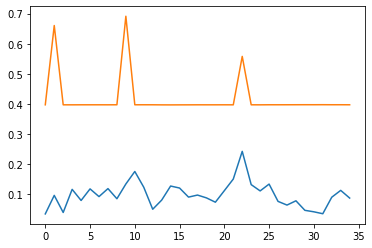

In [84]:
#Визуализация функции лоса:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [85]:
#Расчёт точности работы модели:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))
print('Модель показала примерно такой же результат')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy: 0.9216
Модель показала примерно такой же результат


**Предобученная VGG16**

In [78]:
#Создание предобученной VGG16:
model = models.vgg16(pretrained=True)

In [86]:
#Формирование параметров нейронной сети с линейным классификатором:
num_features = 25088
model.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [88]:
#Обучение модели:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.0186 Acc: 0.9754
val Loss: 0.0971 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.0239 Acc: 0.9590
val Loss: 0.0973 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.0260 Acc: 0.9631
val Loss: 0.0966 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.0219 Acc: 0.9795
val Loss: 0.0973 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.0278 Acc: 0.9590
val Loss: 0.0973 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.0172 Acc: 0.9754
val Loss: 0.0973 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.0235 Acc: 0.9631
val Loss: 0.0973 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.0175 Acc: 0.9877
val Loss: 0.0973 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.0241 Acc: 0.9590
val Loss: 0.0973 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.0186 Acc: 0.9672
val Loss: 0.0974 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.0205 Acc: 0.9631
val Loss: 0.0975 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.0278 Acc: 0.9590
val Loss: 0.0975 Acc: 0.9150

Epoch 12/24
----------
t

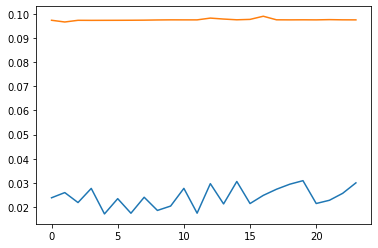

In [89]:
#Визуализация функции лосса:
plt.plot(losses['train'][1:])
plt.plot(losses['val'][1:])

In [91]:
#Расчёт точности работы модели:
print("Accuracy: {0:.4f}".format(evaluate(model)))
print('При неизменных параметрах модель показала достойный результат'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy: 0.9150
При неизменных параметрах модель показала достойный результат
